#Inital settings

In [1]:
import h5py
import os
import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from collections.abc import Iterable
import pandas as pd



In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeissonbarrantes","key":"e1383607b8f7d832dba99bb17f3a1444"}'}

**Steps to follow to obtain kaggle competition data and use it in the notebook**




In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c isic-2024-challenge

!unzip isic-2024-challenge.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_987

**Reading files**

In [4]:
train_metadata = pd.read_csv('./train-metadata.csv')
train_images='./train-image/image'
test_metadata = pd.read_csv('./test-metadata.csv')

<ipython-input-4-27ed0098f2b2>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('./train-metadata.csv')


In [ ]:
train_metadata.head(10)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
5,ISIC_0035502,0,IP_3026693,75.0,female,head/neck,2.54,TBP tile: close-up,3D: white,22.129183,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.619603
6,ISIC_0051648,0,IP_0218255,65.0,male,upper extremity,3.74,TBP tile: close-up,3D: XP,14.319188,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.918133
7,ISIC_0051665,0,IP_7734648,50.0,male,posterior torso,4.31,TBP tile: close-up,3D: XP,20.102610,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.972390
8,ISIC_0051710,0,IP_1307115,50.0,male,anterior torso,3.17,TBP tile: close-up,3D: white,14.166805,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.818963
9,ISIC_0051758,0,IP_2180091,60.0,female,upper extremity,3.97,TBP tile: close-up,3D: XP,16.251490,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999690


In [5]:
train_metadata['anatom_site_general'].value_counts()

,count
anatom_site_general,
posterior torso,121902
lower extremity,103028
anterior torso,87770
upper extremity,70557
head/neck,12046


**Grouping of the data to see how many are in the anatomical sites of each type**

In [6]:
train_metadata.groupby(['anatom_site_general', 'target'])['target'].count()


anatom_site_general  target
anterior torso       0          87688
                     1             82
head/neck            0          11968
                     1             78
lower extremity      0         102955
                     1             73
posterior torso      0         121799
                     1            103
upper extremity      0          70500
                     1             57
Name: target, dtype: int64

Data sample with the grouping of `anatom_site_general`

In [14]:
"""
Agrupa los datos de metadatos del conjunto de entrenamiento por sitio anatómico y objetivo,
luego imprime la cantidad de cada combinación de sitio anatómico y objetivo, y obtiene
información específica de un sitio anatómico particular.

El script realiza las siguientes acciones:
1. Agrupa los datos del DataFrame 'train_metadata' por 'anatom_site_general' y 'target'.
2. Imprime la cantidad de ocurrencias para cada combinación de 'anatom_site_general' y 'target'.
3. Filtra y muestra los datos de un sitio anatómico específico ('head/neck').

Variables:
- grouped_data (Series): Una serie con las cantidades de cada combinación de sitio anatómico y objetivo.
- site (str): El sitio anatómico específico a filtrar ('head/neck').
- data_for_site (Series): Los datos de conteo de la variable 'target' para el sitio anatómico específico.
- target_0_count (int): La cantidad de registros con 'target' igual a 0 para el sitio anatómico específico.
"""

grouped_data = train_metadata.groupby(['anatom_site_general', 'target'])['target'].count()

for (anatom_site, target), count in grouped_data.items():
  print(f"Anatomical Site: {anatom_site}, Target: {target}, Count: {count}")

site = 'head/neck'
data_for_site = grouped_data[site]
print(f"\nData for {site}:\n{data_for_site}")
target_0_count = data_for_site[0]
print(f"\nCount of target 0 in {site}: {target_0_count}")


Anatomical Site: anterior torso, Target: 0, Count: 87688
Anatomical Site: anterior torso, Target: 1, Count: 82
Anatomical Site: head/neck, Target: 0, Count: 11968
Anatomical Site: head/neck, Target: 1, Count: 78
Anatomical Site: lower extremity, Target: 0, Count: 102955
Anatomical Site: lower extremity, Target: 1, Count: 73
Anatomical Site: posterior torso, Target: 0, Count: 121799
Anatomical Site: posterior torso, Target: 1, Count: 103
Anatomical Site: upper extremity, Target: 0, Count: 70500
Anatomical Site: upper extremity, Target: 1, Count: 57

Data for head/neck:
target
0    11968
1       78
Name: target, dtype: int64

Count of target 0 in head/neck: 11968


In [8]:
df=pd.read_csv("./train-metadata.csv" ,usecols=['isic_id','target', 'anatom_site_general'])
df.head()

,isic_id,target,anatom_site_general
0,ISIC_0015670,0,lower extremity
1,ISIC_0015845,0,head/neck
2,ISIC_0015864,0,posterior torso
3,ISIC_0015902,0,anterior torso
4,ISIC_0024200,0,anterior torso


In [ ]:
df['target'].value_counts()

,count
target,
0,400666
1,393


This code splits the dataset into training and validation sets, with 80% of the data used for training and 20% for validation. The train_test_split function separates the features and target variable (df['target']). The training and validation sets are then recombined with their corresponding target values using pd.concat, and the first few rows of the training set are displayed using train.head().

In [9]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid=train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=42)
train=pd.concat([x_train,y_train],axis=1)
valid=pd.concat([x_valid,y_valid],axis=1)
train.head()

,isic_id,anatom_site_general,target
18085,ISIC_0517312,posterior torso,0
171181,ISIC_4318651,anterior torso,0
284095,ISIC_7110993,posterior torso,0
354900,ISIC_8861121,lower extremity,0
77679,ISIC_1994958,posterior torso,0



These lines of code create two separate dataframes: neg contains all rows from the training set where the target variable is 0 (negative class), and pos contains all rows where the target variable is 1 (positive class).


In [10]:
neg= train[train['target']==0]
pos= train[train['target']==1]

In [11]:
neg.groupby(['anatom_site_general']).count()

,isic_id,target
anatom_site_general,,
anterior torso,70143,70143
head/neck,9524,9524
lower extremity,82363,82363
posterior torso,97396,97396
upper extremity,56472,56472


**Visualization of the two types of tumors and how the images look like.**

***Benign tumor***

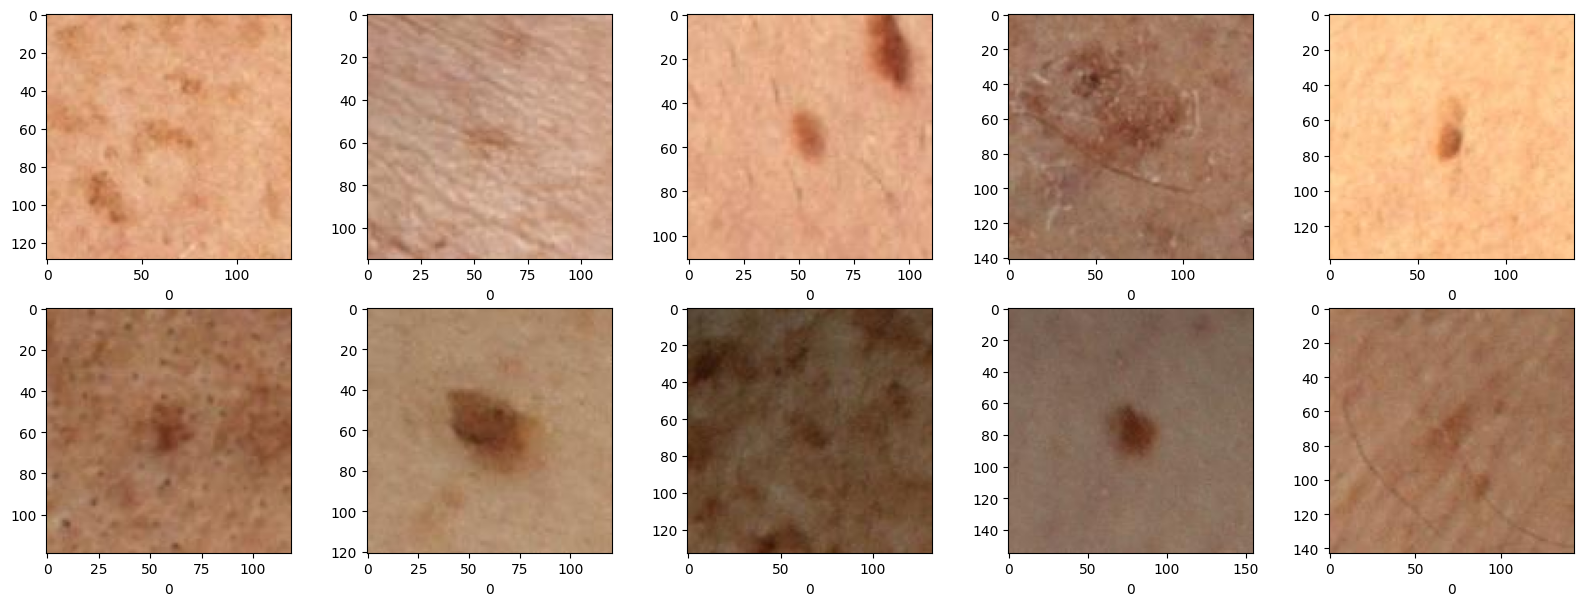

In [12]:
import tensorflow as tf

"""
Visualiza un conjunto de 10 imágenes de un DataFrame de datos negativos utilizando una cuadrícula de subgráficos.

El script realiza los siguientes pasos:
1. Crea una cuadrícula de subgráficos de 2 filas y 5 columnas.
2. Carga 10 imágenes desde un directorio utilizando sus identificadores únicos (ISIC IDs).
3. Convierte cada imagen de BGR a RGB para una visualización correcta con Matplotlib.
4. Muestra cada imagen en su subgráfico correspondiente y etiqueta el eje x con el valor del 'target'.

Variables:
- ax (array de AxesSubplot): Matriz de subgráficos donde se visualizan las imágenes.
- key (str): Identificador único de la imagen en el DataFrame 'neg'.
- img (numpy.ndarray): Imagen cargada y convertida en formato RGB.

Requiere:
- `neg` (DataFrame): DataFrame que contiene las columnas 'isic_id' y 'target'.
- `train_images` (str): Ruta al directorio de las imágenes.
"""

_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    key=neg.loc[neg.index.values[i],'isic_id']
    img=cv2.imread(f'{train_images}/{key}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(neg.loc[neg.index.values[i],'target'])


***Malignant tumor***

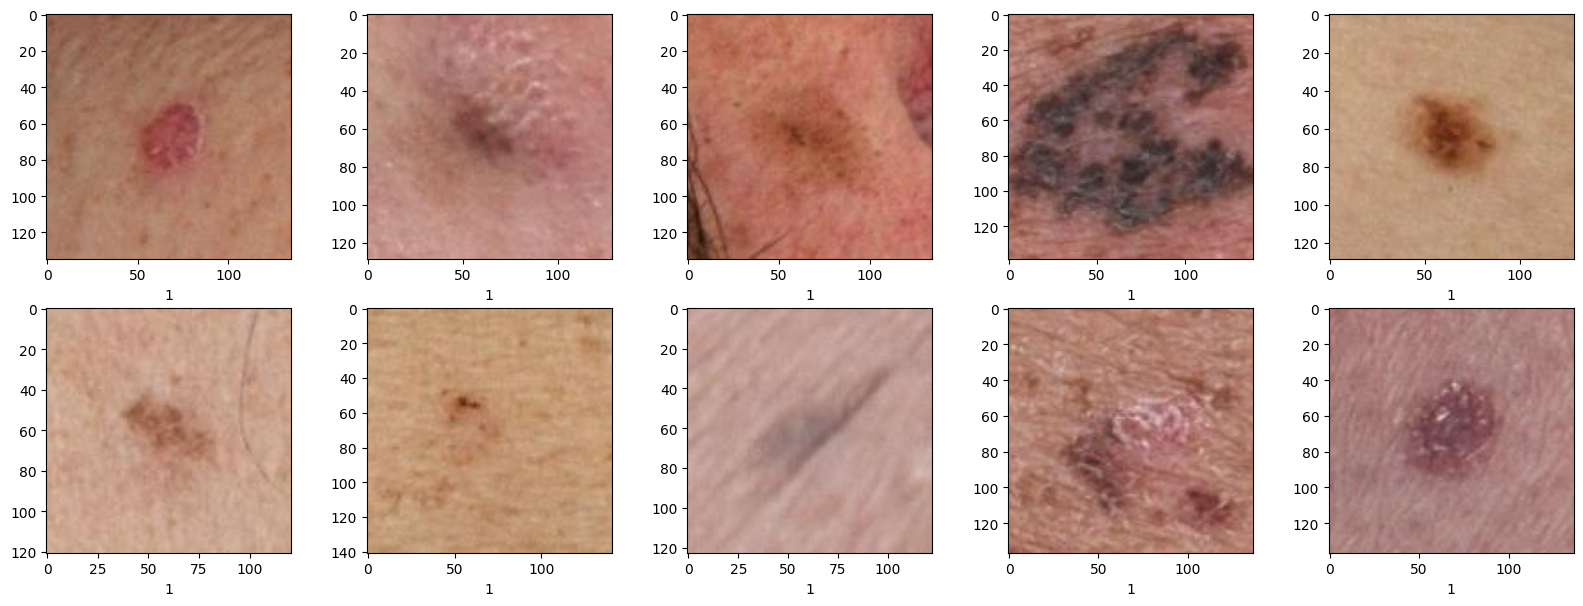

In [13]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    key=pos.loc[pos.index.values[i],'isic_id']
    img=cv2.imread(f'{train_images}/{key}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(pos.loc[pos.index.values[i],'target'])

#Preprocessing

The img_loader function loads a specified number (it) of images from a directory (train_images) based on their IDs from a DataFrame (inc). It reads each image, resizes it to 256x256 pixels, and stores it in a list. The function returns a NumPy array containing all the loaded and resized images.

In [ ]:
def img_loader(inc, train_images, it):
    """
    Carga y redimensiona imágenes desde un directorio específico.

    Parámetros:
    inc (DataFrame): Un DataFrame que contiene información sobre las imágenes, incluyendo los IDs de las imágenes en la columna 'isic_id'.
    train_images (str): La ruta al directorio donde se encuentran las imágenes.
    it (int): El número de imágenes que se van a cargar.

    Retorna:
    numpy.ndarray: Un arreglo de imágenes redimensionadas de tamaño (it, 256, 256, 3).
    """
    arr = []
    for i in range(it):
        key=inc.loc[inc.index.values[i],'isic_id']
        img=cv2.imread(f'{train_images}/{key}.jpg')
        img=cv2.resize(img,(256,256))
        arr.append(img)
    arr=np.array(arr)
    return arr



In [ ]:
tumor_m = img_loader(pos, train_images, pos.shape[0])


In [ ]:
tumor_m[0].shape

(256, 256, 3)

In [ ]:
tumor_b = img_loader(neg, train_images, neg.shape[0]//250 )


In [ ]:
tumor_b[0].shape

(256, 256, 3)

In [ ]:
tumor_b_label = [0] * tumor_b.shape[0]
tumor_m_label = [1] * tumor_m.shape[0]

In [ ]:
train_metadata['anatom_site_general'].value_counts()

,count
anatom_site_general,
posterior torso,121902
lower extremity,103028
anterior torso,87770
upper extremity,70557
head/neck,12046


In [ ]:
X = np.concatenate((tumor_b, tumor_m))
y = np.array(tumor_b_label + tumor_m_label)

This code encodes a list of position labels into integer values using LabelEncoder, and then converts these integer labels into one-hot encoded format using to_categorical. The num_position_classes variable determines the number of unique classes for the one-hot encoding.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

"""
Codifica etiquetas de posiciones anatómicas utilizando un codificador de etiquetas (LabelEncoder)
y las convierte en una representación de codificación *one-hot* para su uso en modelos de aprendizaje profundo.

El script realiza los siguientes pasos:
1. Define una lista de etiquetas de posiciones anatómicas.
2. Utiliza `LabelEncoder` de Scikit-Learn para transformar las etiquetas de texto en valores enteros.
3. Convierte las etiquetas enteras codificadas en una representación de codificación *one-hot* usando `to_categorical`.

Variables:
- position_labels (list): Lista de etiquetas de posiciones anatómicas.
- label_encoder (LabelEncoder): Instancia del codificador de etiquetas.
- integer_encoded (numpy.ndarray): Etiquetas de posiciones anatómicas codificadas como enteros.
- num_position_classes (int): Número de clases únicas en las etiquetas de posición.
- position_one_hot (numpy.ndarray): Representación de codificación *one-hot* de las etiquetas de posiciones anatómicas.
"""

position_labels = ['posterior torso', 'lower extremity', 'anterior torso', 'head/neck', 'upper extremity']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(position_labels)

num_position_classes = len(label_encoder.classes_)
position_one_hot = to_categorical(integer_encoded, num_classes=num_position_classes)

In [ ]:
X = X.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
X = np.mean(X, axis=3, keepdims=True)  # Convert to grayscale

In [ ]:
X[0].shape

(256, 256, 1)

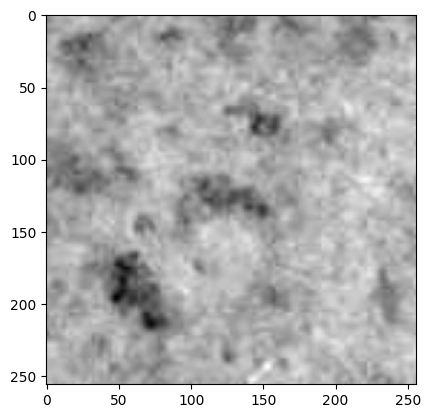

In [ ]:
#Visualization
plt.imshow(X[0], cmap='gray')

In [ ]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes=2 )  # Convert labels to one-hot encoded format

The show_images function displays a grid of images using Matplotlib. It creates a grid of size grid_size x grid_size, randomly selects images from the provided images array, and displays them in grayscale. The function also hides the axes and adjusts spacing between subplots.

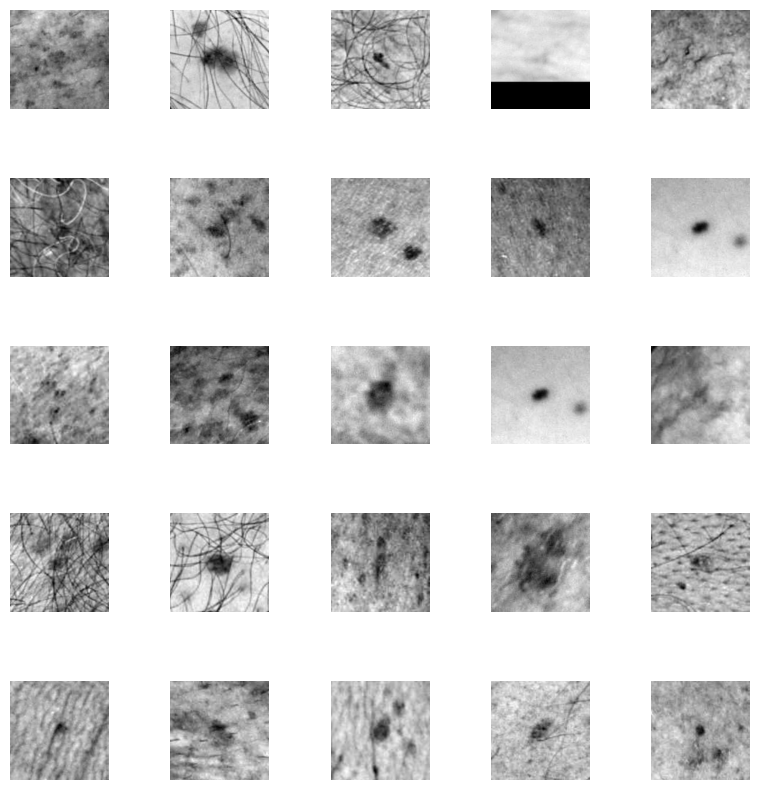

In [ ]:
def show_images(grid_size, images, labels):
    """
    Muestra una cuadrícula de imágenes aleatorias de un conjunto de datos.

    Parámetros:
    grid_size (int): Tamaño de la cuadrícula (número de filas y columnas).
    images (array-like): Conjunto de imágenes a mostrar.
    labels (array-like): Etiquetas correspondientes a las imágenes.

    El script realiza las siguientes acciones:
    1. Crea una cuadrícula de subgráficos de tamaño `grid_size` x `grid_size`.
    2. Selecciona aleatoriamente imágenes del conjunto de datos.
    3. Muestra cada imagen en su respectivo subgráfico sin ejes.

    Uso:
    Llamar a la función `show_images(grid_size, X, y)` donde `X` es el conjunto de imágenes y `y` son las etiquetas.

    """
    fig, axis = plt.subplots(grid_size, grid_size, figsize=(10, 10))  # Create a grid of subplots
    axis = axis.ravel()  # Flatten the axis array for easy access

    data_len = len(images)

    for i in range(0, grid_size * grid_size):  # Iterate through the subplots
        index = np.random.randint(0, data_len)

        axis[i].imshow(images[index], cmap = 'gray')
        axis[i].axis('off')
    plt.subplots_adjust(hspace=0.7)

show_images(5, X, y)

#Training


In [ ]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)  # Shuffle the data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)  # Split training data into training and validation sets

This code snippet builds a convolutional neural network (CNN) for image classification using TensorFlow/Keras. It defines the following:


1.   Class Weights Calculation: Computes class weights to handle class imbalance and creates a dictionary for class weights.

2.   Model Architecture:


  *   Convolutional Layers: Three Conv2D layers with increasing filters, ReLU activation, and dropout for regularization.


  *   Pooling Layers: MaxPooling2D layers to reduce spatial dimensions.

  *   Flattening and Dense Layers: Flattens the output from convolutional layers and adds fully connected layers with ReLU activation and L2 regularization.

  *   Output Layer: A Dense layer with softmax activation for classification into two classes.











In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

"""
Construye un modelo de red neuronal convolucional (CNN) utilizando Keras para la clasificación de imágenes
y calcula los pesos de clase para manejar el desbalance de clases en los datos.

El script realiza los siguientes pasos:
1. Calcula los pesos de clase para equilibrar el entrenamiento de la red neuronal.
2. Crea un modelo secuencial de CNN con capas convolucionales, de agrupamiento, de abandono (Dropout), y densas.

Variables:
- class_weight (numpy.ndarray): Pesos de clase calculados para las clases desbalanceadas.
- class_weight_dict (dict): Diccionario que mapea los índices de clases a los pesos calculados.
- image_model (Sequential): Modelo secuencial de Keras que representa la red neuronal convolucional para clasificación de imágenes.

El modelo de red neuronal tiene la siguiente estructura:
- 3 capas convolucionales (Conv2D) con activación ReLU y agrupamiento máximo (MaxPooling2D).
- Capas de Dropout después de cada agrupamiento para evitar sobreajuste.
- 1 capa de Flatten para aplanar la entrada antes de la capa completamente conectada.
- 1 capa densa con 512 neuronas, activación ReLU, y regularización L2.
- 1 capa de salida densa con 2 neuronas y activación softmax para clasificación binaria.

Requiere:
- `y` (numpy.ndarray): Etiquetas de las imágenes en formato one-hot codificado.
"""


class_weight = compute_class_weight(class_weight= 'balanced', classes= np.unique(np.argmax(y, axis=1)),y = np.argmax(y, axis=1))  # Calculate class weights
class_weight_dict = dict(enumerate(class_weight))  # Create a dictionary mapping class indices to class weights

image_model = Sequential()
image_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
image_model.add(MaxPooling2D(pool_size=(2, 2)))
image_model.add(Dropout(0.25))

image_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))
image_model.add(Dropout(0.25))

image_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))
image_model.add(Dropout(0.25))

image_model.add(Flatten())
image_model.add(Dense(512, activation= 'relu', kernel_regularizer=regularizers.l2(0.01)))
image_model.add(Dense(2, activation='softmax'))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print(image_model.summary())  # Print a summary of the model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,203,074 (256.36 MB)

 Trainable params: 67,203,074 (256.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
image_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])  # Compile the model with categorical cross-entropy loss and Adam optimizer

In [ ]:
history = image_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)  # Train the model


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - accuracy: 0.5103 - loss: 12.3194 - val_accuracy: 0.8170 - val_loss: 3.7271
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - accuracy: 0.8076 - loss: 2.9097 - val_accuracy: 0.8170 - val_loss: 1.4085
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.8072 - loss: 1.2133 - val_accuracy: 0.8170 - val_loss: 0.8609
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 306s 10s/step - accuracy: 0.8226 - loss: 0.7957 - val_accuracy: 0.8170 - val_loss: 0.7315
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 336s 11s/step - accuracy: 0.8131 - loss: 0.7134 - val_accuracy: 0.8170 - val_loss: 0.6952
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 276s 9s/step - accuracy: 0.8099 - loss: 0.6928 - val_accuracy: 0.8170 - val_loss: 0.6858
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 255s 9s/step - accuracy: 0.8261 - loss: 0.6621 - val_accuracy: 0.8170 - val_loss: 0.6765
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 264s 9s/step - accuracy: 0.8246 - loss: 0.6620 - val_accuracy: 0.8170 

This code creates a figure with two subplots to visualize the training history of a model:



*   First Plot: Displays the training accuracy and validation accuracy over epochs.
*   Second Plot: Displays the training loss and validation loss over epochs.
The figure has a size of 16x8 inches, with one row and two columns of plots.




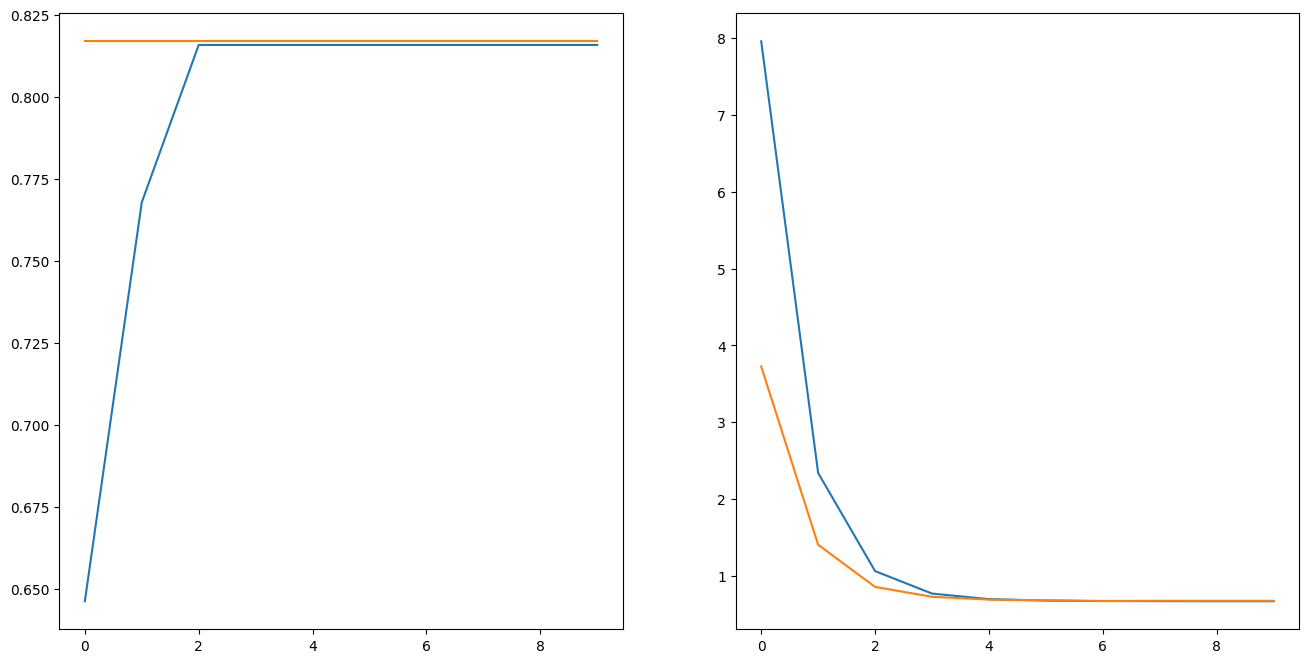

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(16, 8))

axis[0].plot(history.history['accuracy'])
axis[0].plot(history.history['val_accuracy'])

axis[1].plot(history.history['loss'])
axis[1].plot(history.history['val_loss'])

# Predictions


In [ ]:
predictions = image_model.predict(X_test)  # Make predictions on the test data
predictions_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

 3/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step

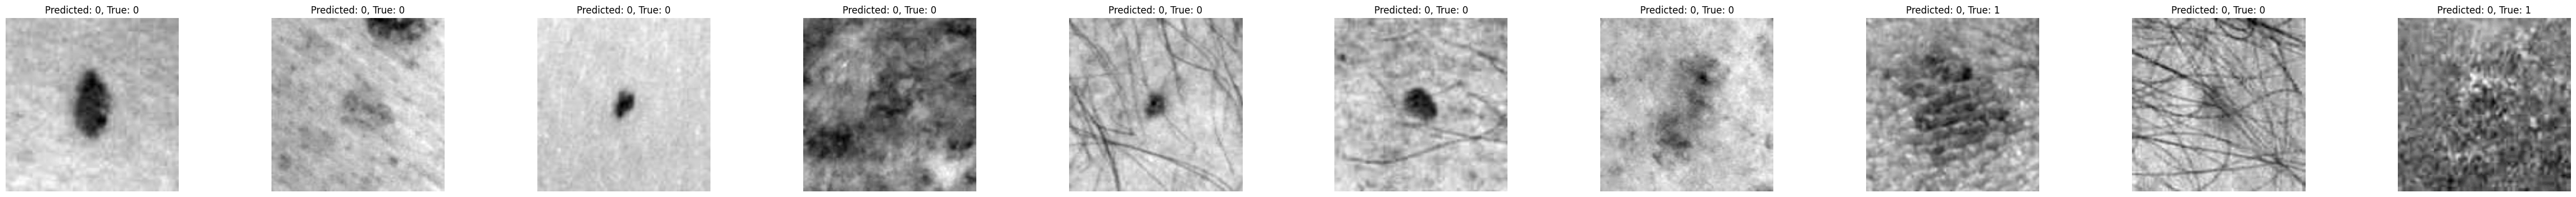

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = 10
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
sample_images = X_test[random_indices]
true_labels = np.argmax(y_test[random_indices], axis=1) # Extract true labels
sample_labels = predictions_labels[random_indices]

fig, axes = plt.subplots(1, num_samples, figsize=(60, 4))
for i, ax in enumerate(axes):
  ax.imshow(sample_images[i], cmap='gray')
  ax.set_title(f"Predicted: {sample_labels[i]}, True: {true_labels[i]}") # Display both predicted and true
  ax.axis('off')
plt.show()